Импорт необходимых библиотек

In [1]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

![Алгоритм Q-Learning](q-learning-alg.png)

![Алгоритм SARSA](sarsa-alg.png)

Определяем класс Агента

In [39]:
# Тестовый агент
class Agent:
    # Конструктор 
    def __init__(self, env, learning_rate=0.1, epsilon=0.1, discount_factor=0.9, max_steps=500):
        # Среда
        self.env = env
        # Скорость обучения
        self.learning_rate = learning_rate
        # Величина дисконтирования
        self.discount_factor = discount_factor
        # Уровень жадности
        self.epsilon = epsilon
        # Длина максимальной траектории
        self.max_steps = max_steps
        # Q-таблица: [состояния x действия]
        self.q_table = np.zeros((env.observation_space.n, env.action_space.n))
        # Счётчик для Монте-Карло
        self.counter = np.zeros((env.observation_space.n, env.action_space.n))
        # Длины траекторий по эпизодам
        self.steps = []
        # Итоговое вознаграждение по эпизодам
        self.rewards = []

    # эпсилон-жадная стратегия выбора действия
    def __epsilon_greedy_action(self, state):
        # С вероятностью epsilon выбираем случайное действие
        # в противном случае берём лучшее действия исходя из текущей Q-таблицы
        if np.random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.q_table[int(state), :])

    # Алгоритм Q-Learning
    def __update_q_table_qlearning(self, state, action, reward, next_state):
        td_target = reward + self.discount_factor * np.max(self.q_table[next_state, :])
        td_error = td_target - self.q_table[state, action]
        self.q_table[state, action] += self.learning_rate * td_error
    
    # Алгоритм SARSA
    def __update_q_table_sarsa(self, state, action, reward, next_state, next_action):
        td_target = reward + self.discount_factor * self.q_table[next_state, next_action]
        td_error = td_target - self.q_table[state, action]
        self.q_table[state, action] += self.learning_rate * td_error
    # Алгоритм Монте-Карло    
    def __update_q_table_monte_carlo(self, episode_transitions):
        returns = 0
        for transition in reversed(episode_transitions):
            state, action, reward, _ = transition
            returns = self.discount_factor * returns + reward
            self.q_table[state, action] += (returns - self.q_table[state, action]) / (1 + self.counter[state, action])
            self.counter[state, action] += 1
            # self.q_table[state, action] += self.learning_rate * (returns - self.q_table[state, action])

    # Обучение Агента
    def train(self, num_episodes, method='qlearning'):
        # Обнуляем прошлый опыт
        self.rewards, self.steps = [], []
        self.q_table = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        # Запускаем цикл эпизодов обучения
        # Взаимодействуем со средой и обновляем 
        # Q-таблицу, по одному из алгоритмов: Q-Learning или SARSA
        for episode in tqdm(range(num_episodes)):
            # self.epsilon = 1 - episode / num_episodes
            state, _ = self.env.reset()
            done = False
            total_reward, steps = 0, 0
            episode_transitions = []
            # Блуждаем пока не завершится эпизод, исходя из данных среды
            while not done and steps < self.max_steps:
                # Выбираем действие по эпсилон-жадной стратегии
                action = self.__epsilon_greedy_action(state)
                # Определяем реакцию среды
                next_state, reward, done, _, _ = self.env.step(action)
                
                # Обновляем таблицу, исходя из выбранного метода
                if method == 'qlearning':
                    self.__update_q_table_qlearning(state, action, reward, next_state)
                elif method == 'sarsa':
                    next_action = self.__epsilon_greedy_action(next_state)
                    self.__update_q_table_sarsa(state, action, reward, next_state, next_action)
                # Сохраняем траекторию движения, вознаграждение и длину траектории
                episode_transitions.append((state, action, reward, next_state))
                state = next_state
                total_reward += reward
                steps += 1
            
            self.rewards.append(total_reward)
            self.steps.append(steps)
            
            if method == 'monte_carlo': self.__update_q_table_monte_carlo(episode_transitions)

    # Отрисовка результатов обучения
    # Выводим вознаграждение и длину траектории
    def plot_rewards(self):
        # Сгладим графики
        window_size = 10
        smoothed_rewards = pd.Series(self.rewards).rolling(window_size, min_periods=window_size).mean()
        smoothed_steps = pd.Series(self.steps).rolling(window_size, min_periods=window_size).mean()

        plt.figure(figsize=(8, 12))
        plt.subplot(2, 1, 1)
        plt.plot(smoothed_rewards)
        plt.xlabel('Эпизод')
        plt.ylabel('Суммарное вознаграждение')
        plt.title('Оценка вознаграждения')

        plt.subplot(2, 1, 2)
        plt.plot(smoothed_steps)
        plt.xlabel('Эпизод')
        plt.ylabel('Длина траектории')
        plt.title('Оценка длины траектории')

        plt.tight_layout()
        plt.show()

In [32]:
agent = Agent(gym.make('Taxi-v3'), max_steps=1000)

100%|██████████| 1000/1000 [00:02<00:00, 439.20it/s]


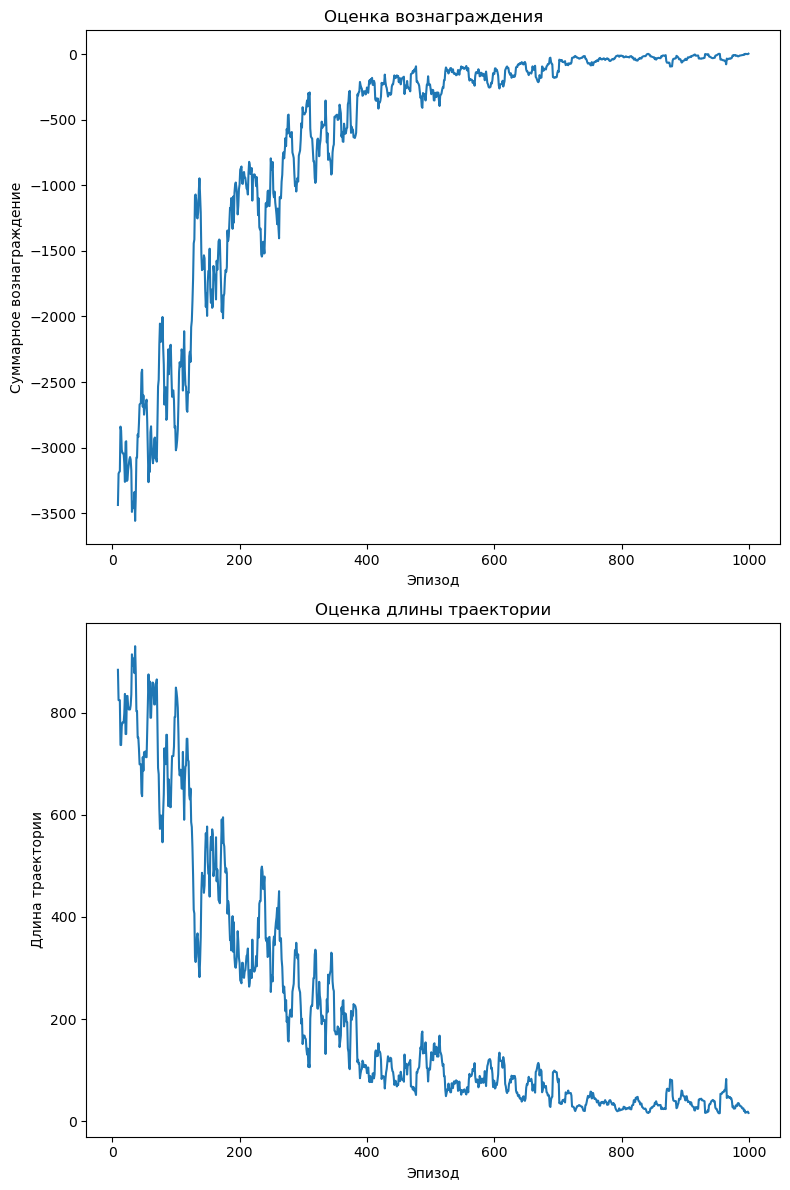

In [40]:
num_episodes = 1000
agent.train(num_episodes, method='sarsa')
agent.plot_rewards()

100%|██████████| 1000/1000 [00:01<00:00, 607.52it/s]


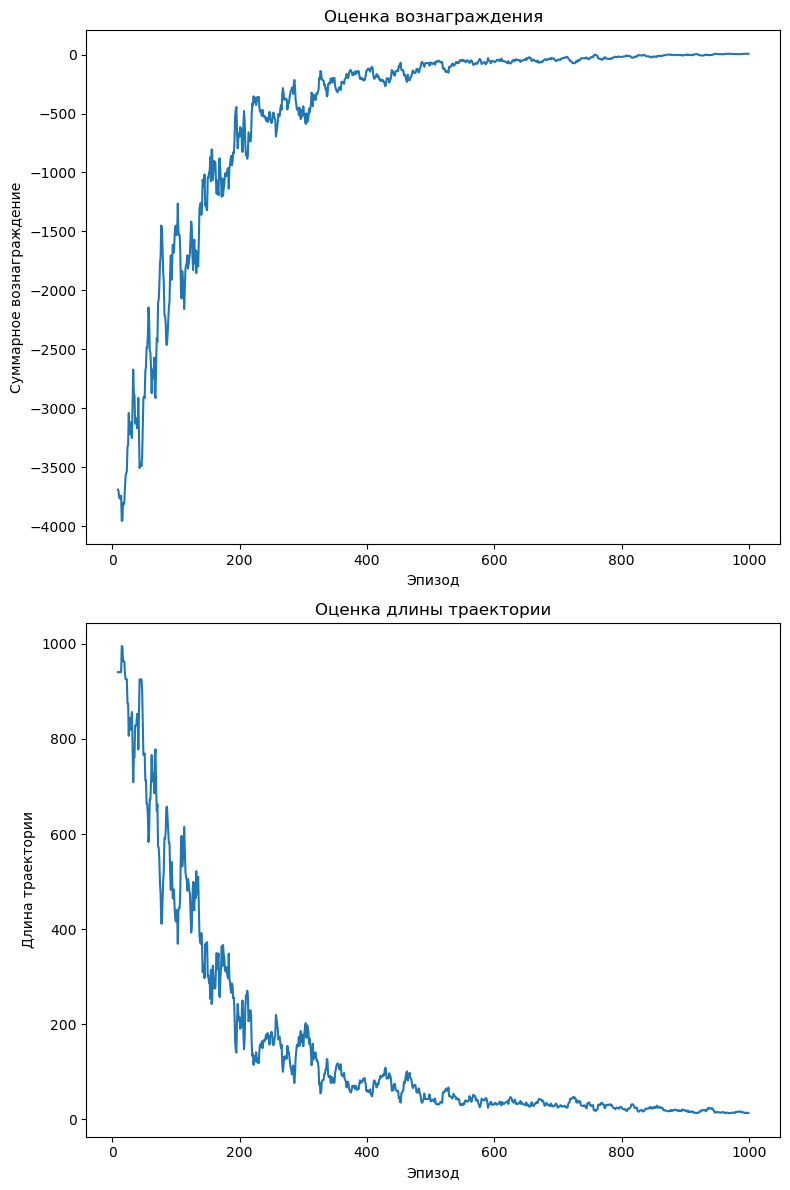

In [41]:
agent.train(num_episodes, method='qlearning')
agent.plot_rewards()

100%|██████████| 20000/20000 [02:17<00:00, 145.25it/s]


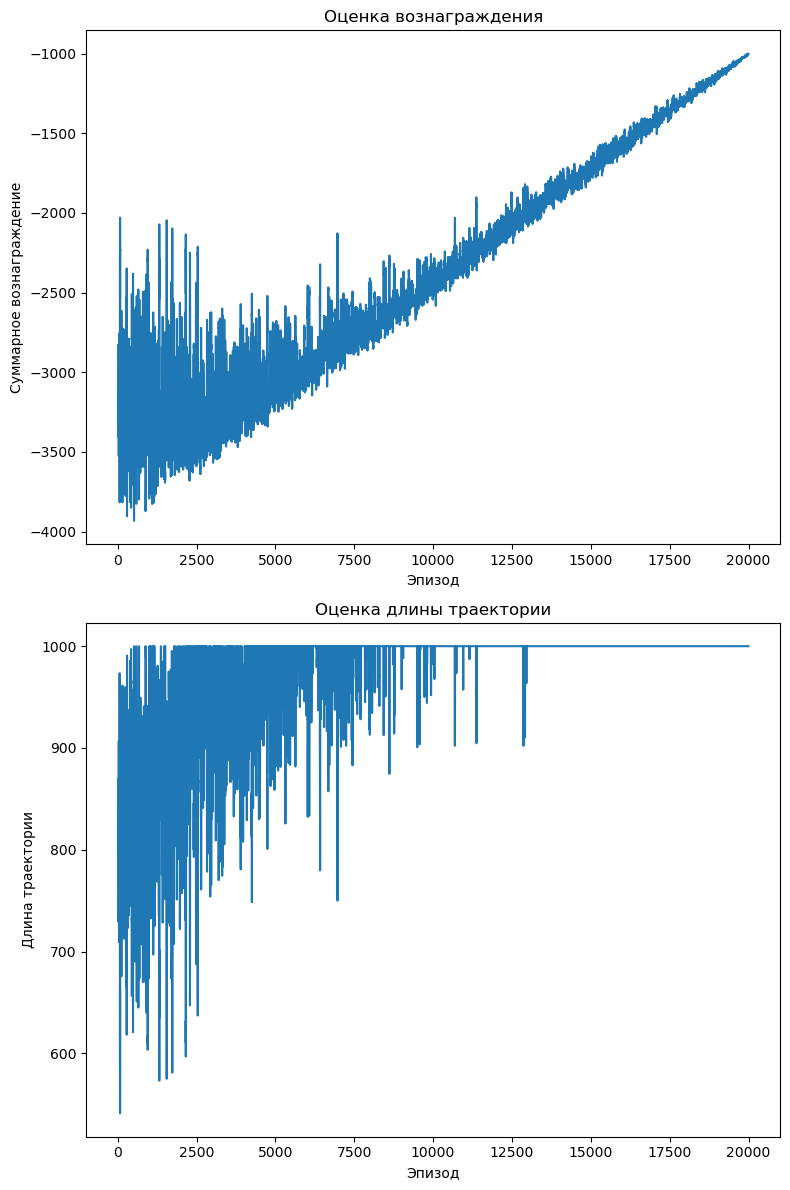

In [42]:
agent.max_steps=1000
agent.discount_factor=0.99
agent.train(num_episodes=20000, method='monte-carlo')
agent.plot_rewards()